# Parallelization with Word Context Vectors

#### By Jo Guldi

Workhorse script to download the Congressional testimony, produce a 5-yr word2vec model for showing change over time + visual analysis

## Setup

In [27]:
import multiprocessing
from multiprocessing import Pool

In [269]:
startdate = 1870
enddate = 2010
n = multiprocessing.cpu_count()
print(multiprocessing.cpu_count())

40


In [271]:
# configuration for m2
import sys
from multiprocessing import Process, Queue, cpu_count
import argparse
CPU_CORES = 2 
def parse_config():
    global CPU_CORES
    parser = argparse.ArgumentParser()
    parser.add_argument('--cores', nargs=1, default=1, type=int, help='Number of cores to use.')
    args = parser.parse_args()
    CPU_CORES = args.cores[0]
    if CPU_CORES < 0 or CPU_CORES > cpu_count():
        raise ValueError('Invalid core number specified.')
parse_config() 

usage: ipykernel_launcher.py [-h] [--cores CORES]
ipykernel_launcher.py: error: unrecognized arguments: -f /users/jguldi/.local/share/jupyter/runtime/kernel-e61299dc-21b0-4cca-852a-d4326e7924ab.json


SystemExit: 2

In [29]:
def parallelize_operation(df, func, n_cores = n):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

## Loading data

In [30]:
import pandas as pd
import gensim 
import csv
import glob
import numpy as np
import multiprocessing
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer
#!pip install wordsegment --user
from wordsegment import load, segment, clean
import string
load()
import re

The following lines load some data from Congress. 

In [5]:
all_speech_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_*.txt')
CONGRESS_MIN_THRESHOLD = 1
CONGRESS_MAX_THRESHOLD = 115

speech_files = []

for fn in all_speech_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        speech_files.append(fn)

speech_files.sort()
        
def parse_one(fn):
    print(f'Reading {fn}...')
    return pd.read_csv(fn, sep='|', encoding="ISO-8859-1", error_bad_lines=False, warn_bad_lines=False, quoting=csv.QUOTE_NONE)

speeches_df = pd.concat((parse_one(fn) for fn in speech_files))
speeches_df.dropna(how='any', inplace=True)

all_description_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/descr_*.txt')
                                  
description_files = []

for fn in all_description_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        description_files.append(fn)
        description_files.sort()
        
description_df = pd.concat((parse_one(fn) for fn in description_files))

all_data = pd.merge(speeches_df, description_df, on = 'speech_id')
all_data.fillna(0, inplace=True)
all_data = all_data.drop(['chamber', 'speech_id', 'number_within_file', 'speaker', 'first_name'], 1)
all_data = all_data.drop(['last_name', 'state', 'gender', 'line_start', 'line_end', 'file', 'char_count', 'word_count'], 1)
all_data['date']=pd.to_datetime(all_data['date'],format='%Y%m%d')
all_data['year'] = pd.to_datetime(all_data['date']).dt.year
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year'], 1)
all_data['index'] = np.arange(len(all_data)) # create an 'index' column
all_data.head()

Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_043.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_044.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_045.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_046.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_047.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_048.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_049.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_050.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_051.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_052.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_053.txt...
Reading /s

,speech,5yrperiod,index
0,The Secretary will read the names of the newly...,1870.0,0
1,said: Mr. President. owing to some inadvertenc...,1870.0,1
2,The question is on the motion of the Senator f...,1870.0,2
3,The order of proceedings will now be formed. f...,1870.0,3
4,of the United States. the PRESIDENTELEcT. The ...,1870.0,4


In [31]:
sample_l = all_data.sample(50000)
sample_m = sample_l.sample(5000)
sample = sample_m.sample(500)

In [32]:
all_data

,speech,5yrperiod,index
0,The Secretary will read the names of the newly...,1870.0,0
1,said: Mr. President. owing to some inadvertenc...,1870.0,1
2,The question is on the motion of the Senator f...,1870.0,2
3,The order of proceedings will now be formed. f...,1870.0,3
4,of the United States. the PRESIDENTELEcT. The ...,1870.0,4
...,...,...,...
17394636,Madam Speaker. on rollcall Nos. 662 and 661. I...,2010.0,17394636
17394637,Madam Speaker. as I leave Congress as the peop...,2010.0,17394637
17394638,Madam Speaker. on rolicall No. 658. I was unav...,2010.0,17394638
17394639,Madam Speaker. on rollcall No. 658 my flight w...,2010.0,17394639


In [33]:
sample

,speech,5yrperiod,index
13259497,Without objection. the nomination is considere...,1975.0,13259497
4619374,The Senator from Arizona has the floor. but th...,1915.0,4619374
7461755,No. the gentleman is entirely mistaken. In the...,1935.0,7461755
6141674,Mr. President. I send to the desk a resolution...,1925.0,6141674
10639986,Mr. Speaker. in my view. the single most impor...,1960.0,10639986
...,...,...,...
1061867,On Wednesday last I presented a petition of im...,1885.0,1061867
6656347,The principal reduction. then. is associated w...,1930.0,6656347
2898982,So that you have already given them retired pa...,1905.0,2898982
8955607,Mr. President. I do not see how the Senator fr...,1950.0,8955607


## Create function for cleaning & structuring the data in parallel

In this section and the next, we will create a function, then launch that function with parallelize_operation.

In [9]:
# WORKING 4-17
def cleanup(df):

    df = sentences_df2.reset_index()
    df2 = df  
    
    # To remove punctuation:
    for i, sentence in enumerate(df['sentence']):
        sentence2 = []
        for word in sentence:
            word2 = re.sub('\W', '', word).lower()
            if len(word2)>0:
                sentence2.append(word2)
        #df2['sentence'][index] = sentence2 #<---- ERROR HERE
        #df2.at[index, 'sentence'] = sentence2 
        df2.at[df2.index[i],'sentence'] = sentence2 
        #df2['5yrperiod'][index] = df['5yrperiod'][index]

        

    # To remove any strings shorter than 10 words:
    df2 = df2[
        df2['sentence'].apply(lambda x: len(x)>10) ]
        
    return(df2)
    

In [10]:
def structure_me(data): # FAILS
    
    sentences_df =pd.concat([data['speech'].str.split('.').explode()],axis=1).reset_index() #explode the data 


    return(sentences_df)

In [11]:
def structure_me2(data): # WORKING
    
    sentences_df =pd.concat([data['speech'].str.split('.').explode()],axis=1).reset_index() #explode the data 
    
    sentences_df = sentences_df.rename({'speech' : 'sentence'}, axis = 1) # rename the column "sentence" to "keyword"
    sentences_df['sentence'] = sentences_df['sentence'].str.lower().copy() # lowercase the data

    word_context_sentences = pd.merge(data, sentences_df, on="index")  # merge 
    word_context_sentences = word_context_sentences.drop(['index'],1)
    sentences_df = word_context_sentences.drop(['speech'],1)
    
    return(sentences_df)

In [12]:
def structure_me3(data): # WORKING 4-16
   
    df = data
    
    # Getting s as pandas series which has split on full stop and new sentence a new line
    s = df['speech'].str.split('.').apply(pd.Series,1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'sentence' # needs a name to join

    del df['speech']
    df = df.join(s)
    del df['index']

    
    return df


In [13]:
def split_sentences3(data): #  WORKING BUT FAILS PARALLEL 4-16
    
    data['sentence'] = data['sentence'].str.split(' ')
    
    return(data)

In [14]:
def split_sentences4(data): #  WORKING BUT FAILS PARALLEL 4-16
    
    data2 = data
    data2['sentence'] = data['sentence'].str.split(' ')
    
    return(data2)

In [15]:
def split_sentences_into_words(sentences_df): # FAILS
 
    sentences_df2 = sentences_df
    
    # To split sentences into strings:
    for sentence, index in enumerate(sentences_df['sentence']):
            sentence_df2['sentence'][index] = sentence.split()

   #     sents = []
    
   # for sentence in sentences_df['sentence']:
            #sentence = clean(sentence)
            #sentence = segment(sentence) # segment is like split, but uses a dictionary to guess that "i lovea d uck" should be "i love a duck"
            #type(sentence)
           # s2 = sentence.split()
            #print(s2)
           # if len(s2) > 1:
             #   sents.append(s2)
                
   # sents = pd.DataFrame(sents)
    

    return(sentence_df2)

## Making GENSIM Word Embeddings for every 5yr period

In [16]:
periodnames = all_data['5yrperiod'].unique().tolist()

In [ ]:
keyword_context = [] # create an empty dummy variable

for period1 in periodnames:
    
    # just the data in the period in question, then clean it
    period_data = all_data[all_data['5yrperiod'] == period1]

    sentences_df = parallelize_operation(period_data, structure_me3) #  split speech into sentences
    sentences_df2 = split_sentences3(sentences_df) # split sentences into words
    sentences_df3 = cleanup(sentences_df2) # cleanup punctuation and empty lines
    
    # make a gensim model for that data
    period_model = gensim.models.Word2Vec( 
        sentences = sentences_df3['sentence'],
        workers= n,
        iter = 15,
        min_count = 20, 
        size = 100)  
    
    # save the model with the name of the period
    period_model.save('model-' + str(period1)) 
    
    # load model for each 5 yr period - one period per cycle of the for loop
    #period_model = gensim.models.Word2Vec.load('model-' + str(period1)) # to load a saved model

    # append each period to a larger model of all congress
    if period1 == periodnames[0]:
        congress_model = period_model # for the first time, save period_model as congress model
    else:    
        congress_model.build_vocab(sentences_df3['sentence'], # after the first period, add new period data to the congress model
                               update = True)
        congress_model.train(sentences_df3['sentence'], total_examples=period_model.corpus_count, epochs=period_model.epochs) 

    # store the model with the name of the period
    congress_model.save('congress_model-' + str(startdate) + '-' + str(enddate))        

## Analysis of a keyword in context over time

#### Search the by-period data generated by the loop above

In [261]:
keyword1 = 'feminine'  # define the keyword you're looking for. you can change this variable as many times as you want.

In [262]:
enddate = 1950

In [263]:
#########  after the first run, use this line to call the old data without generating it again
keyword_context = []
dates_found = []

for p in range(0, 18) :

    period1 = periodnames[p]
    print('working on ', period1)
    period_model = gensim.models.Word2Vec.load('model-' + str(period1)) # to load a saved model

    ## analysis
    if keyword1 in period_model.wv.vocab:
        print('found ', keyword1)
        keyword_context_period = period_model.wv.most_similar(keyword1, topn = 5000) # extract the context of how women were talked about in that period
        keyword_context.append(keyword_context_period) # save the context of how women were talked about for later
        dates_found.append(period1)

working on  1870.0
working on  1875.0
working on  1880.0
working on  1885.0
working on  1890.0
working on  1895.0
working on  1900.0
working on  1905.0
working on  1910.0
working on  1915.0
found  feminine
working on  1920.0
working on  1925.0
working on  1930.0
working on  1935.0
working on  1940.0
working on  1945.0
working on  1950.0
working on  1955.0


#### Visualize Changing Context of a Word with GENSIM Vectors

In [264]:
all_words = []
for i in range(len(dates_found)):
    words = [item[0] for item in keyword_context[i]][:10]
    all_words.append(words)

all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

numwords = 10


In [265]:
# helper function to abstract only unique values while keeping the list in the same order -- the order of first appearance
def unique2(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [266]:
from matplotlib import cm
from numpy import linspace
colors = [ cm.viridis(x) for x in linspace(0, 1, len(unique2(all_words2))+10) ]

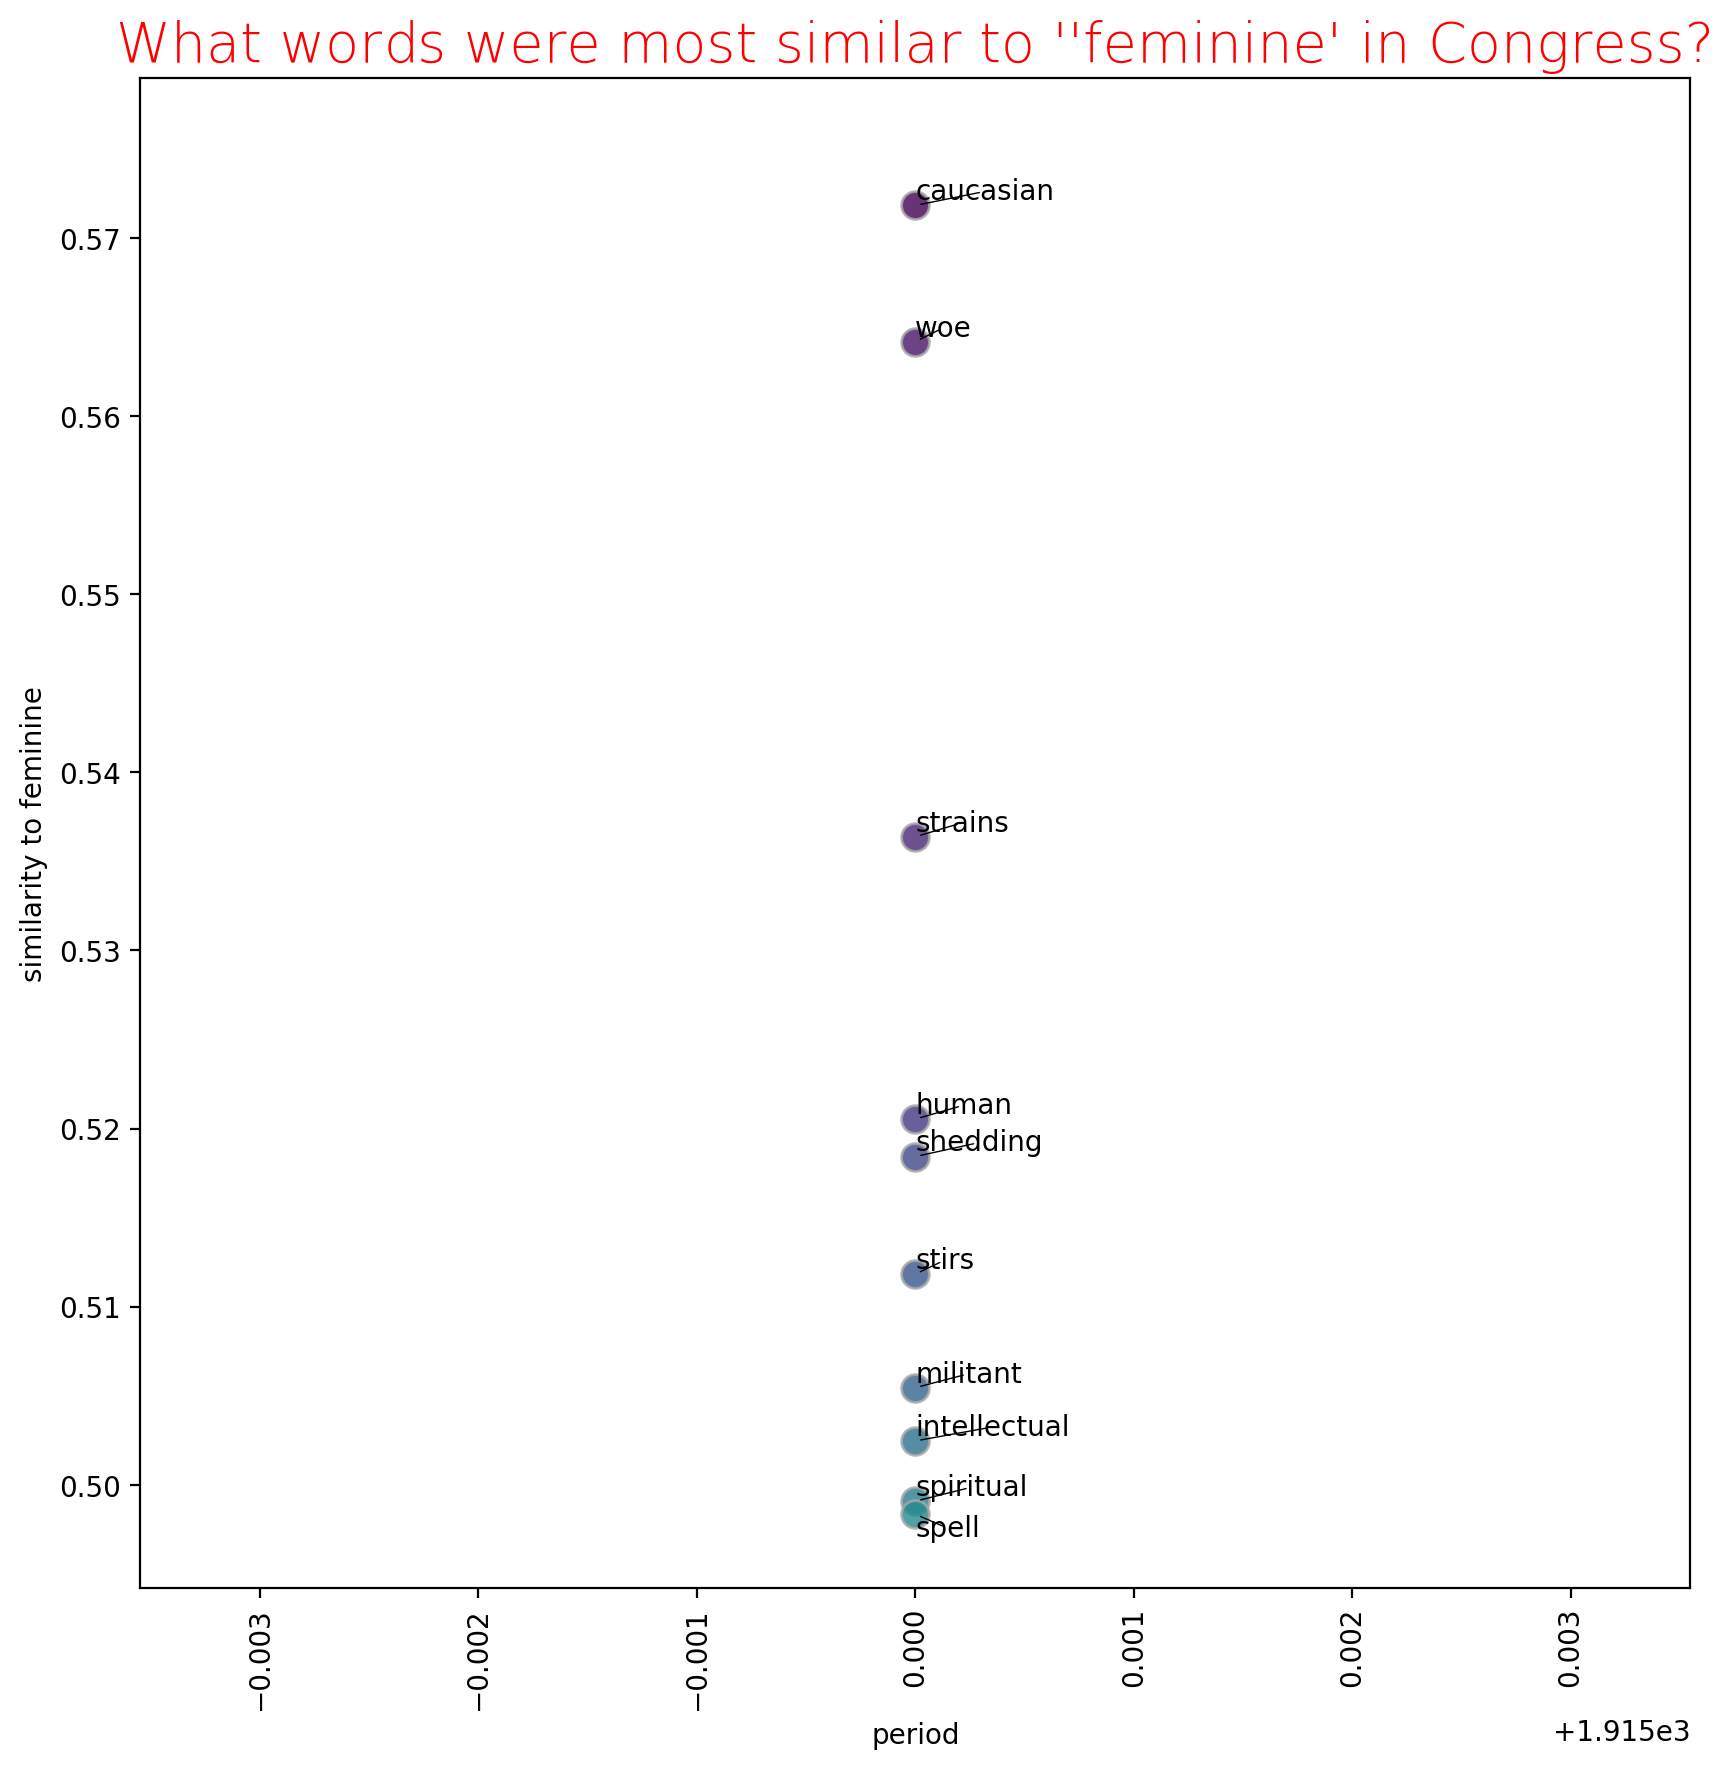

In [267]:
%matplotlib inline
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from adjustText import adjust_text

# change the figure's size here
plt.figure(figsize=(10,10), dpi = 200)

texts = []

# plt.annotate only plots one label per iteration, so we have to use a for loop 
for i in range(len(dates_found)):    # cycle through the period names
    
    #yyy = int(keyword_per_year[keyword_per_year['5yrperiod'] == int(xx)]['count'])   # how many times was the keyword used that year?
                     
    for j in range(10):     # cycle through the first ten words (you can change this variable)
        
        xx = dates_found[i]        # on the x axis, plot the period name
        yy = [item[1] for item in keyword_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
        txt = [item[0] for item in keyword_context[i]][j]        # grab the name of each collocated word
        colorindex = unique2(all_words2).index(txt)   # this command keeps all dots for the same word the same color
        
        plt.scatter(                                             # plot dots
            xx, #x axis
            yy, # y axis
            linewidth=1, 
            color = colors[colorindex],
            edgecolors = 'darkgray',
            s = 100, # dot size
            alpha=0.8)  # dot transparency

        # make a label for each word
        texts.append(plt.text(xx, yy, txt))

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=.7, 
                    expand_points=(1, 1), expand_text=(1, 1),
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xticks(rotation=90)

# Add titles
plt.title("What words were most similar to ''" + keyword1 + "' in Congress?", fontsize=20, fontweight=0, color='Red')
plt.xlabel("period")
plt.ylabel("similarity to " + keyword1)


filename = 'words-similar-to-' + keyword1 + '-' + str(startdate) + '-' + str(enddate)
plt.savefig(filename)